In [2]:
import pandas as pd
import numpy as np
import os
import sys
import gc
from sklearn.manifold import TSNE
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import scipy 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import utils
reload(utils)

<module 'utils' from '/Users/milk/Desktop/git_repositories/READMISSIONS/washtenaw_case_study/notebooks/utils.py'>

In [3]:
matplotlib.rcParams['figure.dpi'] = 200
plt.style.use('seaborn-deep')

In [4]:
"""
file paths
"""

GOOGLE_PATH = "../image_data/google_features.csv"
EIGEN_PATH = "../image_data/eigen_features.csv"
EDUCATION_PATH = "../demographic_data/Education_Data_2015.csv"
INCOME_PATH = "../demographic_data/Income_Data_2015.csv"
OCCUPATION_PATH = "../demographic_data/Occupation_Data_2015.csv"
AA_500_CITIES_PATH = "../demographic_data/demographic_data/Ann_Arbor_500_Cities.csv"


# Google Features and Demographics

In [5]:
"""
Load demographics paths anf filter by county
"""

COUNTY = ' Washtenaw County' # note, as annoying as it is, the whitespace is critical

edu_df = pd.read_csv(EDUCATION_PATH)
edu_df[['Census Tract', 'County', 'State']] = edu_df['NAME'].str.split(',',expand=True)
edu_df['GEOID'] = edu_df['GEOID'].astype(int)
print(f"edu_df.shape {edu_df.shape}")
print()

inc_df = pd.read_csv(INCOME_PATH)
inc_df[['Census Tract', 'County', 'State']] = inc_df['NAME'].str.split(',',expand=True)
inc_df['GEOID'] = inc_df['GEOID'].astype(int)
print(f"inc_df.shape {inc_df.shape}")
print()

occ_df = pd.read_csv(OCCUPATION_PATH)
occ_df[['Census Tract', 'County', 'State']] = occ_df['NAME'].str.split(',',expand=True)
occ_df['GEOID'] = occ_df['GEOID'].astype(int)
print(f"occ_df.shape {occ_df.shape}")
print()

edu_df.shape (100, 42)

inc_df.shape (100, 34)

occ_df.shape (100, 78)



In [6]:
"""
load google features and merge demographics
"""
data_df = pd.read_csv(GOOGLE_PATH)
data_df['GEOID'] = data_df['GEOID'].astype(int)
print(f"data_df.shape: {data_df.shape}")

data_df = pd.merge(data_df, edu_df, how='left', on='GEOID')
print(f"data_df.shape: {data_df.shape}")

data_df = pd.merge(data_df, inc_df, how='left', on='GEOID')
print(f"data_df.shape: {data_df.shape}")

data_df = pd.merge(data_df, occ_df, how='left', on='GEOID')
print(f"data_df.shape: {data_df.shape}")

print(f"WARNING! Dropping non-Washtenaw county images")
data_df = data_df[data_df['County'] == ' Washtenaw County']
print(f"data_df.shape: {data_df.shape}")


data_df.shape: (5964, 729)
data_df.shape: (5964, 770)
data_df.shape: (5964, 803)
data_df.shape: (5964, 880)
WARNING! Dropping non-Washtenaw county images
data_df.shape: (5013, 880)


In [7]:
"""
load eigen features
"""
eig_df = pd.read_csv(EIGEN_PATH)
print(eig_df.shape)
eig_df.head(2)

data_df = pd.merge(data_df, eig_df, left_on='image_index', right_on='tile_index', how='left')
print(data_df.shape)

(5964, 3001)
(5013, 3881)


# Cluster Analysis on Manually Curated labels

In [8]:
ALL_LABEL_COLS = [x for x in data_df.columns if 'label' in x]
print(f"Number of Distinct Labels: {len(ALL_LABEL_COLS)}")

MANUAL_LABELS = [x.strip() for x in open("../image_data/manual_labels.txt")]
print(f"Number of Distinct Labels in curated list: {len(MANUAL_LABELS)}")

Number of Distinct Labels: 326
Number of Distinct Labels in curated list: 99


In [9]:
REDS = [x for x in data_df.columns if 'red_eig' in x]
BLUES = [x for x in data_df.columns if 'blue_eig' in x]
GREENS = [x for x in data_df.columns if 'green_eig' in x]

In [10]:
# occ_df.columns
# [x for x in data_df.columns if 'higher' in x]

In [11]:
# data_df.columns.to_list()

In [12]:
# """
# Cluster images by one-hot encoded labels
# """

# TITLE = 'All Google Label Clustering on Images by Median Household Income'
# TARGET_COL = 'Median income (dollars)!!Estimate!!Households'
# SAMPLE_SIZE = len(data_df) # all data
# FEATURES = MANUAL_LABELS
# PERPLEXITY = 13
# MISSING_VALUE_DICT = {
#     '(X)':np.nan,
#     '-':np.nan,
#     '**':np.nan
# }

# sample = data_df.sample(SAMPLE_SIZE)
# sample[TARGET_COL] = sample[TARGET_COL].replace(MISSING_VALUE_DICT).astype(float)

# embedded = TSNE(n_components=2, 
#                 perplexity=PERPLEXITY).fit_transform(sample[FEATURES])
# print(embedded.shape)


# fig = utils.build_fig(title=f"{TITLE}",
#                       y_lab="TSNE-2", 
#                       x_lab="TSNE-2")

# scat = plt.scatter(embedded[:, 0], 
#             embedded[:, 1], 
#             c=sample[TARGET_COL],
#             s=3, 
#             alpha=0.7,
#             cmap='RdYlGn')

# plt.colorbar()
# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')

In [13]:
# """
# Cluster images by color coverage
# """

# TITLE = 'All Color Features by Median Household Income'
# TARGET_COL = 'Median income (dollars)!!Estimate!!Households'
# SAMPLE_SIZE = len(data_df)
# FEATURES = [x for x in data_df.columns if 'COLOR' in x]
# PERPLEXITY = 50
# MISSING_VALUE_DICT = {
#     '(X)':np.nan,
#     '-':np.nan,
#     '**':np.nan
# }

# sample = data_df.sample(SAMPLE_SIZE).fillna(0)
# sample[TARGET_COL] = sample[TARGET_COL].replace(MISSING_VALUE_DICT).astype(float)

# embedded = TSNE(n_components=2, 
#                 perplexity=PERPLEXITY).fit_transform(sample[FEATURES])


# fig = utils.build_fig(title=f"{TITLE}",
#                       y_lab="TSNE-2", 
#                       x_lab="TSNE-2")

# scat = plt.scatter(embedded[:, 0], 
#             embedded[:, 1], 
#             s=3, 
#             c=sample[TARGET_COL],
#             alpha=0.7,
#             cmap='RdYlGn')

# plt.colorbar()
# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')

In [14]:
# """
# Cluster images by color coverage
# """

# TITLE = 'Red Features by Median Household Income'
# TARGET_COL = 'Median income (dollars)!!Estimate!!Households'
# SAMPLE_SIZE = len(data_df)
# FEATURES = REDS 
# PERPLEXITY = 50
# MISSING_VALUE_DICT = {
#     '(X)':np.nan,
#     '-':np.nan,
#     '**':np.nan
# }

# sample = data_df.sample(SAMPLE_SIZE).fillna(0)
# sample[TARGET_COL] = sample[TARGET_COL].replace(MISSING_VALUE_DICT).astype(float)


# embedded = TSNE(n_components=2, 
#                 perplexity=PERPLEXITY).fit_transform(sample[FEATURES])


# fig = utils.build_fig(title=f"{TITLE}",
#                       y_lab="TSNE-2", 
#                       x_lab="TSNE-2")

# scat = plt.scatter(embedded[:, 0], 
#             embedded[:, 1], 
#             s=3, 
#             c=sample[TARGET_COL],
#             alpha=0.7,
#             cmap='RdYlGn')

# plt.colorbar()
# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')

In [15]:
# """
# Cluster images by color coverage
# """

# TITLE = 'All Features by Median Household Income'
# TARGET_COL = 'Median income (dollars)!!Estimate!!Households'
# SAMPLE_SIZE = len(data_df)
# FEATURES = REDS + BLUES + GREENS + ALL_LABEL_COLS + [x for x in data_df.columns if 'COLOR' in x]
# PERPLEXITY = 50
# MISSING_VALUE_DICT = {
#     '(X)':np.nan,
#     '-':np.nan,
#     '**':np.nan
# }

# sample = data_df.sample(SAMPLE_SIZE).fillna(0)
# sample[TARGET_COL] = sample[TARGET_COL].replace(MISSING_VALUE_DICT).astype(float)


# embedded = TSNE(n_components=2, 
#                 perplexity=PERPLEXITY).fit_transform(sample[FEATURES])


# fig = utils.build_fig(title=f"{TITLE}",
#                       y_lab="TSNE-2", 
#                       x_lab="TSNE-2")

# scat = plt.scatter(embedded[:, 0], 
#             embedded[:, 1], 
#             s=3, 
#             c=sample[TARGET_COL],
#             alpha=0.7,
#             cmap='RdYlGn')

# plt.colorbar()
# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')

In [16]:
# """
# can we predict median income using these features?
# """

# FEATURES = REDS + BLUES + GREENS + ALL_LABEL_COLS + [x for x in data_df.columns if 'COLOR' in x]
# TITLE = 'All Features Lasso Regression for Median Income'
# TARGET_COL = 'Median income (dollars)!!Estimate!!Households'
# MISSING_VALUE_DICT = {
#     '(X)':np.nan,
#     '-':np.nan,
#     '**':np.nan
# }

# # drop where target na
# data_df[TARGET_COL] = data_df[TARGET_COL].replace(MISSING_VALUE_DICT)
# tmp = data_df[data_df[TARGET_COL].notna()]

# target = tmp[TARGET_COL].astype(float).apply(np.log)
# feats = tmp[FEATURES].fillna(-9999)

# X_train, X_test, y_train, y_test = train_test_split(feats,
#                                                     target, 
#                                                     test_size=0.33, 
#                                                     random_state=42)

# print(f"X_train.shape: {X_train.shape}")
# print(f"X_test.shape: {X_test.shape}")
# print(f"y_train.shape: {y_train.shape}")
# print(f"y_test.shape: {y_test.shape}")

# # clf = linear_model.LinearRegression()
# clf = linear_model.Lasso(alpha=10)
# clf.fit(X_train, y_train)
# y_preds = clf.predict(X_test)


# fig = utils.build_fig(title=f"Actual vs Predictions")

# scat = plt.scatter(y_test, 
#                    y_preds,
#                    s=3, 
#                    alpha=0.7)


# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')

In [17]:
"""
how to the eigenvalues relate to the labels?
"""
SAMPLE_SIZE = len(data_df)
MIN_LABEL_THRESHOLD = 2
FEATURES = REDS + BLUES + GREENS
MISSING_VALUE_DICT = {
    '(X)':np.nan,
    '-':np.nan,
    '**':np.nan
}

sample = data_df.sample(SAMPLE_SIZE)
new_rows = []

for idx, target in enumerate(MANUAL_LABELS):
    # print(f"working {target}: ({idx}/{len(MANUAL_LABELS)})")

    if sample[target].sum() >= MIN_LABEL_THRESHOLD:

        subset = sample[sample[target].notnull()]
        subset = subset.fillna(-999999)

        X_train, X_test, y_train, y_test = train_test_split(subset[FEATURES],
                                                            subset[target], 
                                                            test_size=0.33, 
                                                            stratify=subset[target])

        clf = linear_model.LogisticRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        total = np.sum([tn, fp, fn, tp ])
        auc = roc_auc_score(y_test, y_pred)

        row = {
            'Target':target,
            'AUCROC':auc,
            'True_Positive': tp/total,
            'False_Positive': fp/total,
            'True_Negative': tn/total,
            'False_Negative': fn/total,
            'Sensitivity': tp / (tp + fn),
            'Specificity': tn / (tn + fp),
            'Sample_Size': SAMPLE_SIZE

        }

        new_rows.append(row)


res = pd.DataFrame(new_rows)
res.to_csv("../outputs/label_prediction.csv", index=False)
res.head().round(4)


,Target,AUCROC,True_Positive,False_Positive,True_Negative,False_Negative,Sensitivity,Specificity,Sample_Size
0,Aerial_photography_label,0.6637,0.0743,0.0574,0.7559,0.1124,0.3981,0.9294,5013
1,Archaeological_site_label,0.5000,0.0000,0.0000,0.9946,0.0054,0.0000,1.0000,5013
2,Architecture_label,0.6618,0.0773,0.0393,0.7535,0.1299,0.3732,0.9505,5013
3,Bedrock_label,0.4979,0.0000,0.0042,0.9946,0.0012,0.0000,0.9958,5013
4,Beige_label,0.8022,0.3764,0.0906,0.4266,0.1063,0.7797,0.8248,5013


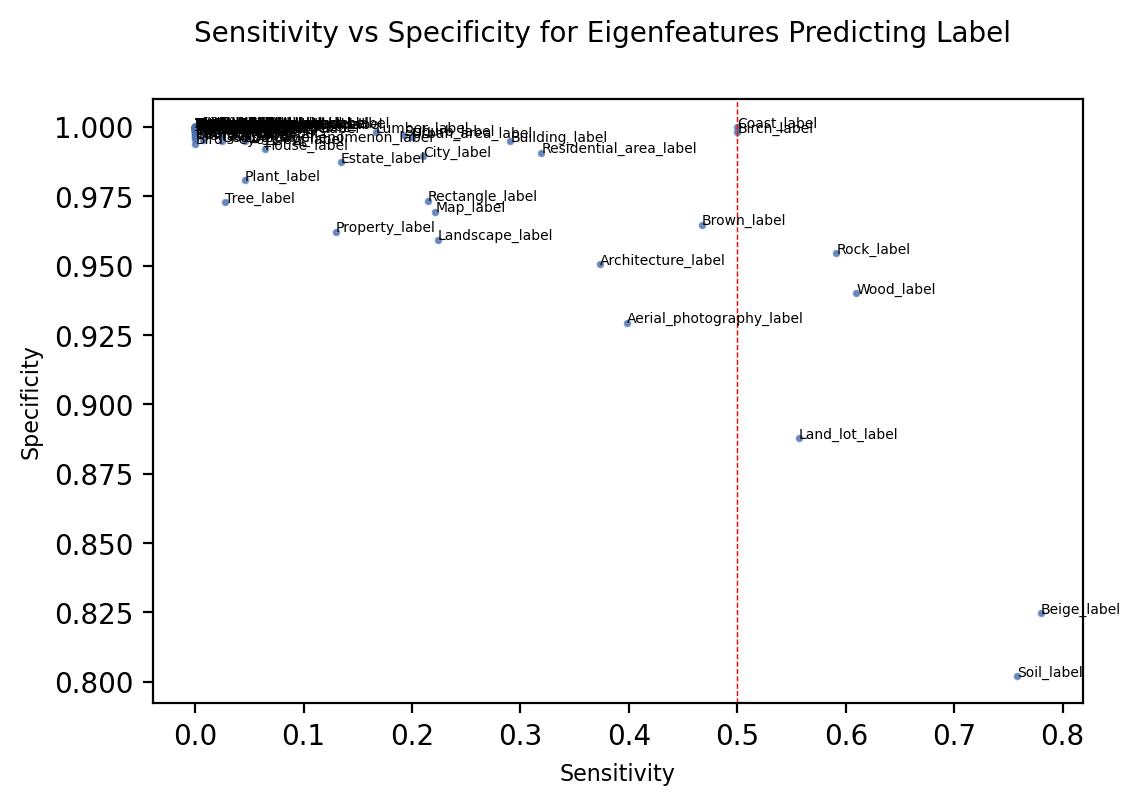

In [18]:
TITLE = "Sensitivity vs Specificity for Eigenfeatures Predicting Label"

fig, ax = plt.subplots()
ax.scatter(res['Sensitivity'],  
           res['Specificity'], 
           s=3, 
           alpha=0.7)

for i, txt in enumerate(res['Target']):
    ax.annotate(txt, (res['Sensitivity'][i], res['Specificity'][i]), fontsize=5)

plt.axvline(0.5, color='r', ls='--', lw=0.5)
fig.suptitle(TITLE, fontsize=10)
plt.xlabel('Sensitivity', fontsize=8)
plt.ylabel('Specificity', fontsize=8)
save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')


In [19]:
"""
Let's do tttest for each label on median income
"""

TARGET_COL = 'Median income (dollars)!!Estimate!!Households'
NAN_POLICY = 'omit'
MISSING_VALUE_DICT = {
    '(X)':np.nan,
    '-':np.nan,
    '**':np.nan
}

tmp = data_df.copy()

tmp[TARGET_COL] = tmp[TARGET_COL].replace(MISSING_VALUE_DICT).astype(float)

new_rows = []

for col in MANUAL_LABELS:

    labeled = tmp[tmp[col] == 1]
    unlabeled = tmp[tmp[col] == 0]

    T, pval = scipy.stats.ttest_ind(labeled[TARGET_COL], 
                        unlabeled[TARGET_COL], 
                        nan_policy=NAN_POLICY)

    row = {
        'Label':col,
        'N_labeled':len(labeled),
        'N_unlabeled':len(unlabeled),
        'Labeled_mean':labeled[TARGET_COL].mean(),
        'Unabeled_mean':unlabeled[TARGET_COL].mean(),
        'T-Obs':T,
        'p-Value':pval,
        'Bonferroni_Alpha': 1 - (1 - 0.05)**0.5
    }

    new_rows.append(row)

res = pd.DataFrame(new_rows)
res['Reject'] = np.where(res['p-Value'] <= res['Bonferroni_Alpha'], 'True', 'False' )
res.to_csv("../outputs/Median_Income_TTests_by_label.csv", index=False)


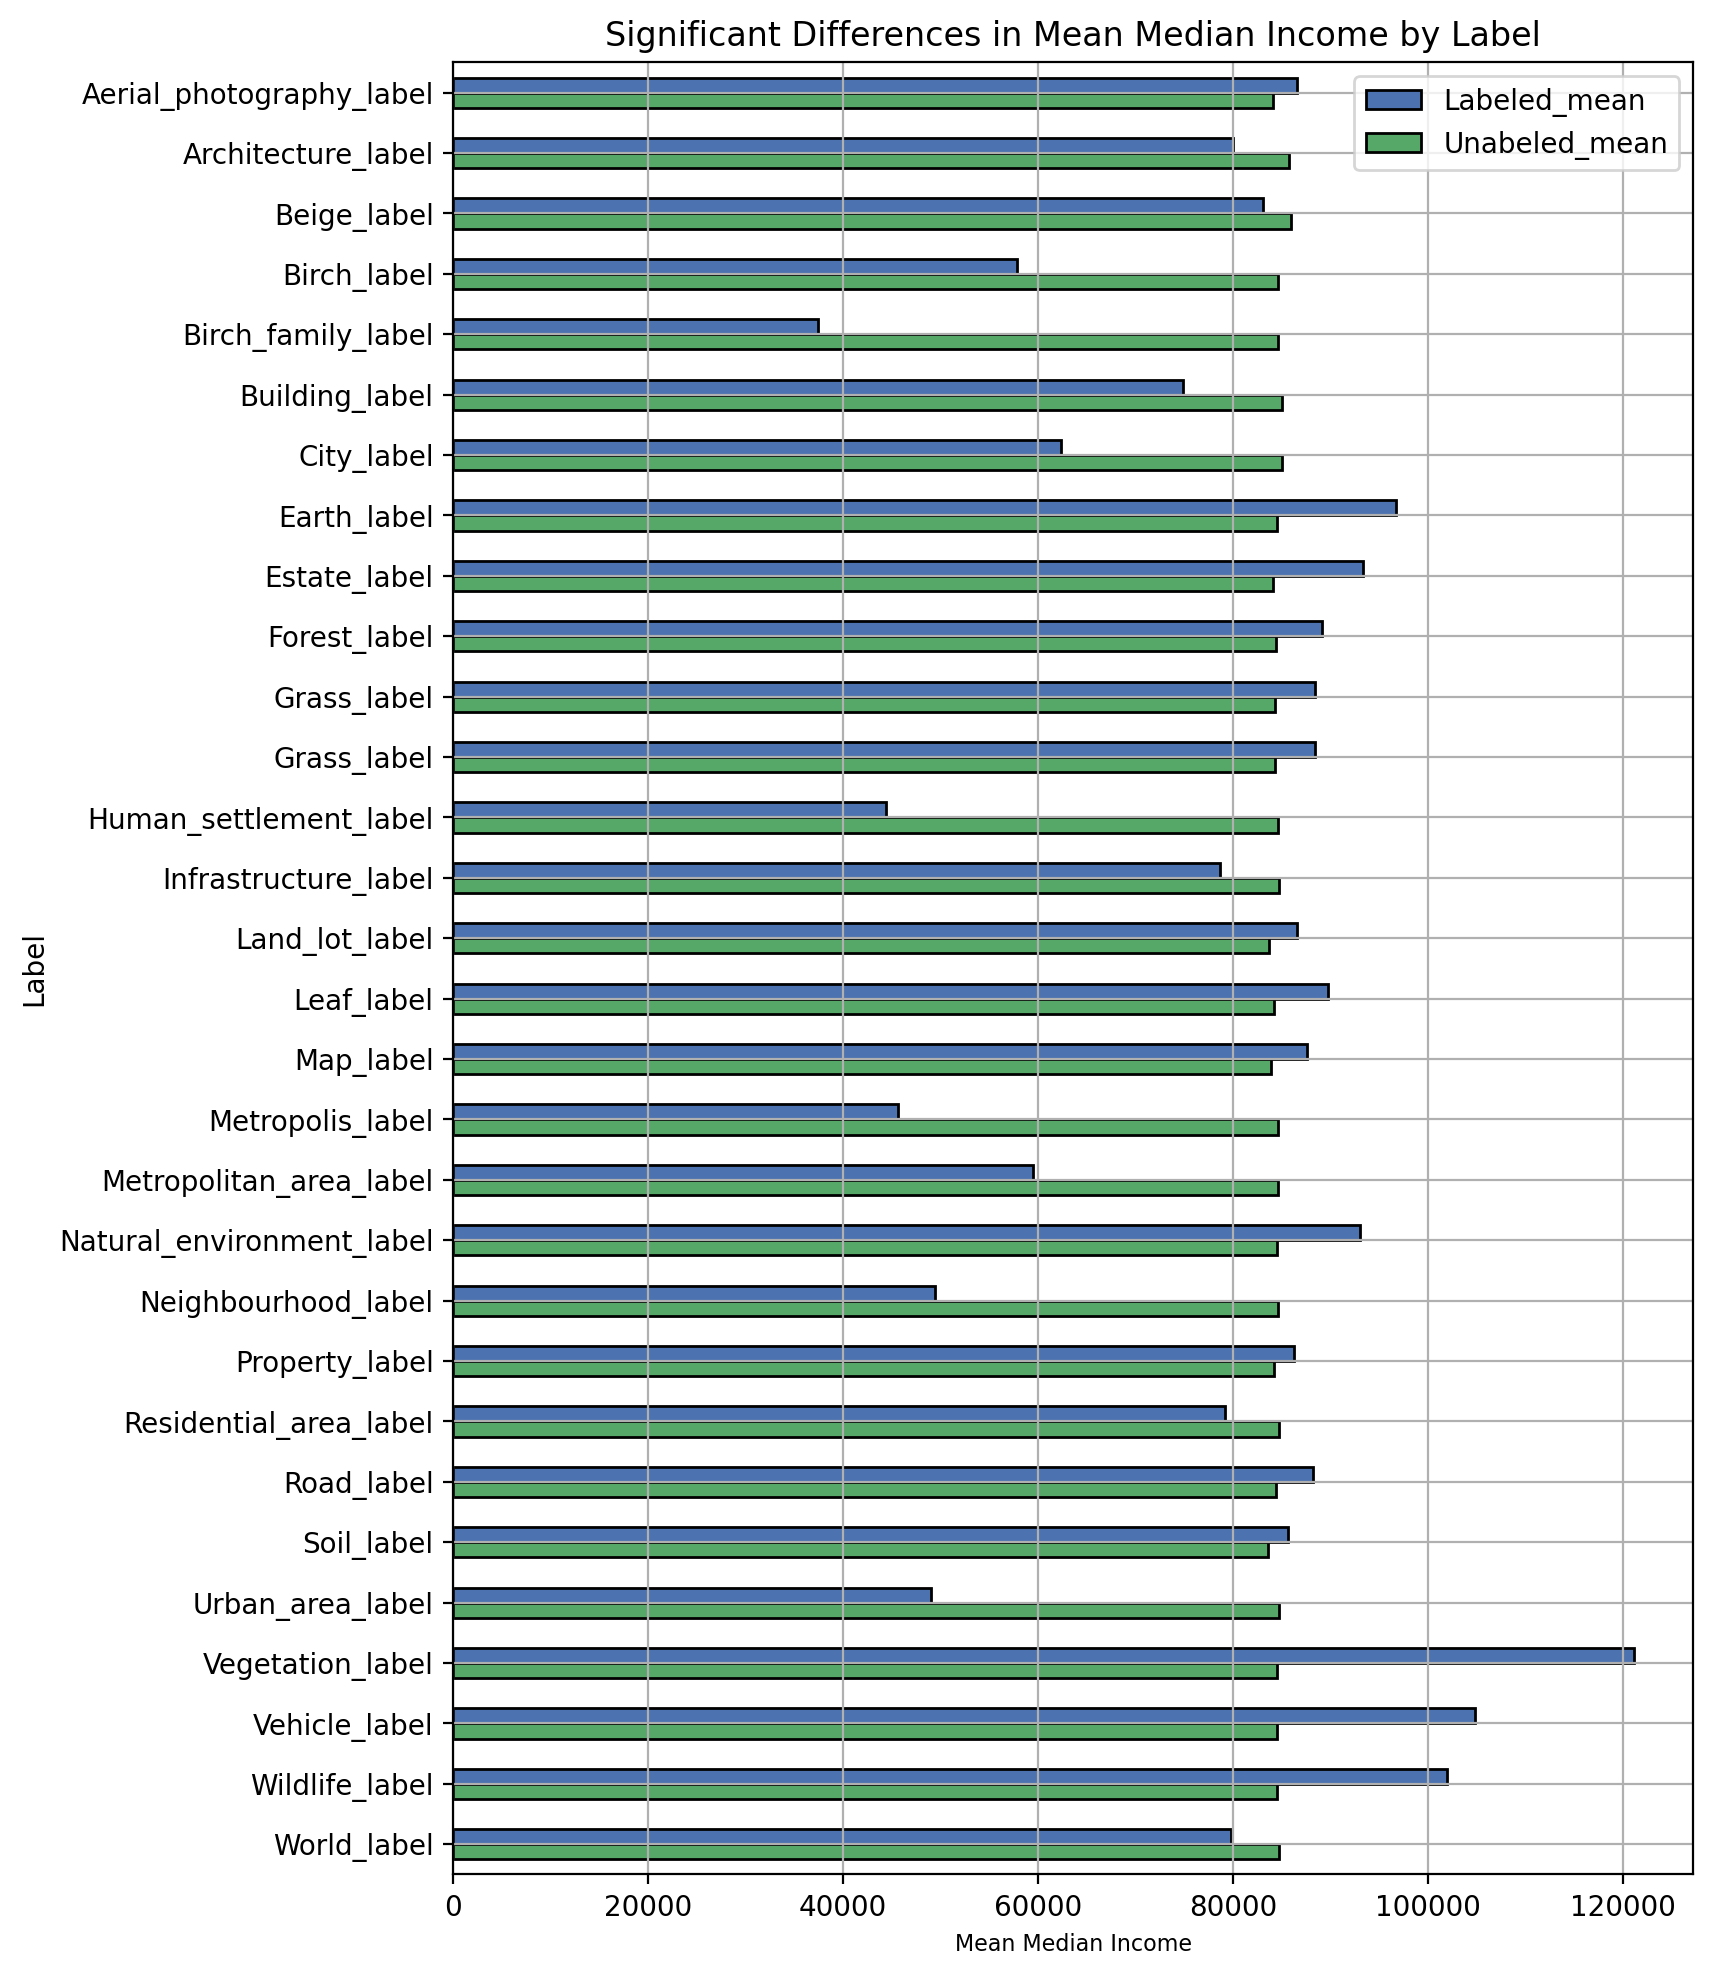

In [20]:
TITLE = 'Significant Differences in Mean Median Income by Label'

sigs = res[res['Reject'] == 'True']
sigs.set_index('Label', inplace=True)
sigs = sigs[['Labeled_mean', 'Unabeled_mean']]
sigs.plot(kind='barh', edgecolor='black', figsize=(8, 12), title=TITLE)
plt.grid()
plt.xlabel('Mean Median Income', fontsize=8)
plt.gca().invert_yaxis()
save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')

In [21]:
data_df.head()

,Abseiling_label,Adaptation_label,Adventure_label,Aerial_photography_label,Amusement_park_label,Amusement_ride_label,Ancient_rome_label,Antique_label,Apartment_label,Arcade_label,...,blue_eig_991,blue_eig_992,blue_eig_993,blue_eig_994,blue_eig_995,blue_eig_996,blue_eig_997,blue_eig_998,blue_eig_999,blue_eig_1000
0,0,0,0,0,0,0,0,0,0,0,...,2.869129,2.537908,2.063795,2.020026,1.771241,1.563943,0.896316,0.494682,0.211528,0.044257
1,0,0,0,0,0,0,0,0,0,0,...,3.470981,3.009629,2.361901,1.923912,1.751543,1.265105,1.083160,0.749636,0.654097,0.226061
2,0,0,0,0,0,0,0,0,0,0,...,3.291750,2.898913,2.588453,2.412453,1.951029,1.512802,1.440446,0.998019,0.539556,0.048014
3,0,0,0,0,0,0,0,0,0,0,...,3.410401,3.115535,2.783957,2.237531,1.509916,1.329670,1.128742,0.854100,0.407354,0.213916
4,0,0,0,0,0,0,0,0,0,0,...,3.243908,3.191757,2.773401,2.312393,1.647995,1.508362,0.994718,0.816073,0.257799,0.050827


In [23]:
data_df.to_csv("../cleaned_data/clean_data.csv", index=False)
print("done")

done
